In [13]:
from templates import *

In [16]:
device = 'cuda:3'
conf = font32_autoenc_10K()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'/home/devesh_temp/scratch/diffae_hpc/diffae/checkpoints/font128_autoenc_trained_style/last.ckpt', map_location='cpu')
# state = torch.load(f'/home/devesh_temp/scratch/diffae_hpc/diffae/checkpoints/font128_autoenc/epoch=44-step=278125.ckpt')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 120.90 M


In [18]:
# data = ImageDataset('/home/devesh_temp/scratch/diffae_new/diffae/imgs_interpolate/font', image_size=(64,64), exts=['jpg', 'JPG', 'png'], do_augment=False)
data = ImageDataset('./run_on_these', image_size=(64,64), exts=['jpg', 'JPG', 'png'], do_augment=False)

batch = torch.stack([
    data[0]['img'],
    data[1]['img']])

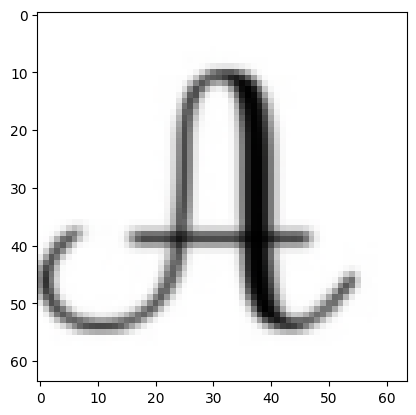

In [19]:
import matplotlib.pyplot as plt
plt.imshow(batch[1].permute([1, 2, 0]) / 2 + 0.5)

In [20]:
cond = model.encode(batch.to(device), None, None)
xT = model.encode_stochastic(batch.to(device), cond, T=250)

# instead of generating it here, sample from xT ∼ N (0, I)
# alpha = 0.5
# rand = torch.randn_like(xT)
# xT = alpha * rand + (1-alpha) * xT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


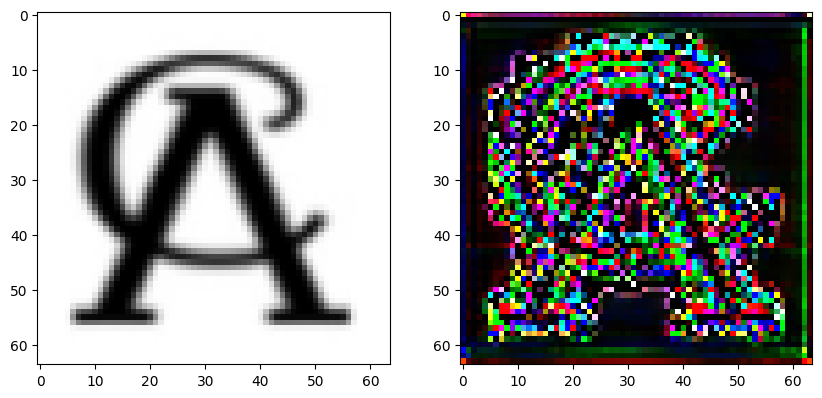

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [22]:

import numpy as np
import torchvision.transforms as transforms 
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device) 
intp = cond[0][None] * (1 - alpha[:, None])  + cond[1][None] * alpha[:, None]
# intp = cond[1][None] *(1-alpha[:, None]*0)
def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
# intp_x = (1 - alpha[:, None] * 0 ) * xT[0].flatten(0, 2)[None]
intp_x = intp_x.view(-1, *x_shape)
resize_transform = transforms.Resize((128, 256))
pred = model.render(intp_x, intp, T=20)
# Create a new list to store the resized images
pred = [resize_transform(image) for image in pred]

/home/devesh_temp/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


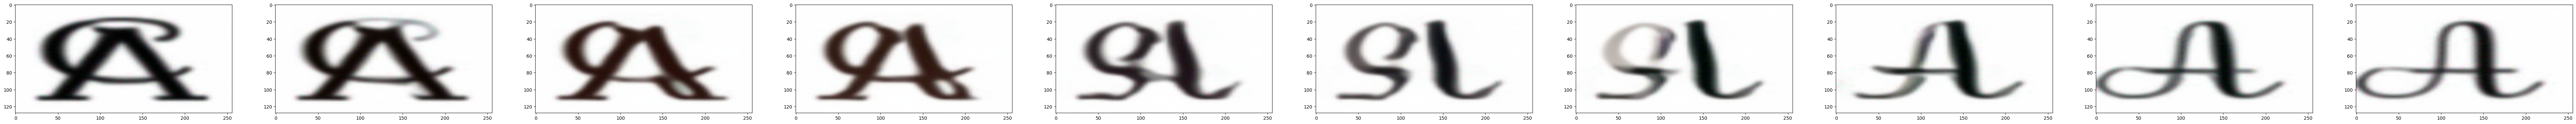

In [24]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 10, figsize=(10*10, 20))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
